In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dhruvildave/english-handwritten-characters-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'english-handwritten-characters-dataset' dataset.
Path to dataset files: /kaggle/input/english-handwritten-characters-dataset


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv(path + "/english.csv")
df.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [3]:
import os
print(os.listdir(path))

['english.csv', 'Img']


In [ ]:
#resizing all the images in the Img folder to 28x28
from PIL import Image
import os
import re

# The images are located in the directory pointed to by the original 'path' variable
# from the cell that downloaded the dataset, and the image paths are in the 'df' dataframe.
# Let's create a new directory to save the resized images.
resized_image_dir = "resized_images"
os.makedirs(resized_image_dir, exist_ok=True)

# Use the 'path' variable directly from the dataset download cell (Fh_1Lx9n0EeP)
# This variable should contain the correct path to the extracted dataset directory.
dataset_path = path
print(f"Using dataset path: {dataset_path}")

# Iterate through the image paths in the dataframe
for index, row in df.iterrows():
    image_path_relative = row['image']
    # Construct the absolute path to the image using the dataset_path
    image_path_absolute = os.path.join(dataset_path, image_path_relative)

    if os.path.isfile(image_path_absolute):
        try:
            im = Image.open(image_path_absolute)
            # Get the filename without extension from the relative path
            filename_without_ext = os.path.splitext(os.path.basename(image_path_relative))[0]
            # Define the new path for the resized image in the resized_image_dir
            new_image_path = os.path.join(resized_image_dir, filename_without_ext + '_resized.jpg')

            # Using LANCZOS filter for better quality when resizing
            imResize = im.resize((28,28), Image.LANCZOS)
            imResize.save(new_image_path, 'JPEG', quality=90)
        except Exception as e:
            print(f"Could not process image {image_path_absolute}: {e}")
    else:
        print(f"Image not found: {image_path_absolute}")

print(f"Resized images saved to '{resized_image_dir}' directory.")

Using dataset path: /kaggle/input/english-handwritten-characters-dataset


KeyboardInterrupt: 

In [5]:
print(path)

/kaggle/input/english-handwritten-characters-dataset


In [11]:
import numpy as np
from PIL import Image
import os
from sklearn.preprocessing import OneHotEncoder

# Define the directory where resized images are saved
resized_image_dir = "resized_images"

# Get the list of resized image filenames
resized_image_files = [f for f in os.listdir(resized_image_dir) if f.endswith('_resized.jpg')]
resized_image_files.sort() # Ensure consistent order

# Initialize lists to store image data and corresponding labels
image_data = []
labels = []

# Load the resized images and extract labels
for image_file in resized_image_files:
    image_path = os.path.join(resized_image_dir, image_file)
    try:
        img = Image.open(image_path).convert('L') # Convert to grayscale
        img_array = np.array(img)

        # Check if the image array is valid (2D and not empty) before appending
        if img_array.ndim == 2 and img_array.shape[0] > 0 and img_array.shape[1] > 0:
            image_data.append(img_array)

            # Extract the original filename from the resized filename to find the label in the dataframe
            original_filename = image_file.replace('_resized.jpg', '.png') # Assuming original extension was .png
            # Find the row in the dataframe that matches the original filename
            # We need to find a robust way to link the resized image back to the original dataframe row and its label.
            # A possible approach is to store the original index or a unique identifier in the resized filename,
            # or rely on sorting if the order is guaranteed.
            # For now, let's assume we can match based on the original filename part.
            # This might be inefficient for a large dataset. A better approach would be to
            # create a new dataframe with paths to resized images and their labels during the resizing step.

            # Let's create a mapping from original filename (without path) to label from the original df
            if 'original_filename_to_label' not in locals():
                 original_filename_to_label = df.set_index(df['image'].apply(lambda x: os.path.basename(x)))['label'].to_dict()

            original_base_filename = original_filename # The filename without the 'Img/' prefix
            if original_base_filename in original_filename_to_label:
                 labels.append(original_filename_to_label[original_base_filename])
            else:
                 # Handle cases where a label is not found (shouldn't happen if all images were processed)
                 print(f"Warning: Label not found for original file: {original_filename}")
                 labels.append(None) # Or some other indicator
        else:
            print(f"Warning: Image file {image_file} did not result in a valid 2D array.")


    except Exception as e:
        print(f"Could not load or process image {image_file}: {e}")

# Convert image data to a numpy array
# Add a check to ensure image_data is not empty before converting to array
if not image_data:
    print("Error: No valid image data was loaded.")
    # You might want to exit or handle this case appropriately
    # For now, we'll print the error and the script will likely stop or error out later
else:
    image_data = np.array(image_data)

    # Flatten images into 1D vectors (28*28 = 784)
    n_samples, height, width = image_data.shape
    image_data_flattened = image_data.reshape(n_samples, height * width)

    # Normalize pixel values to [0, 1]
    image_data_normalized = image_data_flattened / 255.0

    # Remove any samples for which a label was not found
    valid_indices = [i for i, label in enumerate(labels) if label is not None]
    image_data_normalized = image_data_normalized[valid_indices]
    labels = [labels[i] for i in valid_indices]


    # Encode labels using one-hot encoding
    # Reshape labels to be a 2D array for OneHotEncoder
    labels_array = np.array(labels).reshape(-1, 1)

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False) # Use sparse_output=False for a dense array

    # Fit and transform labels
    labels_one_hot = encoder.fit_transform(labels_array)

    print("Original image data shape:", image_data.shape)
    print("Flattened image data shape:", image_data_flattened.shape)
    print("Normalized image data shape:", image_data_normalized.shape)
    print("Original labels length:", len(labels))
    print("One-hot encoded labels shape:", labels_one_hot.shape)

    # Display the first few normalized images and one-hot encoded labels
    # print("\nFirst 5 normalized images (flattened):")
    # print(image_data_normalized[:5])

    # print("\nFirst 5 one-hot encoded labels:")
    # print(labels_one_hot[:5])

Original image data shape: (1100, 28, 28)
Flattened image data shape: (1100, 784)
Normalized image data shape: (1100, 784)
Original labels length: 1100
One-hot encoded labels shape: (1100, 20)


### Perceptron Learning Algorithm (PLA) Implementation

The standard Perceptron Learning Algorithm is designed for binary classification. Since our dataset has multiple classes, we would typically need to use a strategy like one-vs-all or one-vs-one to extend PLA for multi-class classification.

For demonstration purposes, I will implement a basic binary PLA and train it to distinguish between two specific classes from the dataset (e.g., '0' and '1').

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Let's use the full dataset for multi-class classification
# Assuming 'image_data_normalized' and 'labels' from the previous cell are available

X = image_data_normalized  # Normalized image data
y = np.array(labels)       # Original labels

# Get the unique classes and their count
unique_classes = np.unique(y)
NUM_CLASSES = len(unique_classes)
print(f"Number of unique classes: {NUM_CLASSES}")

# Map original labels to integers from 0 to NUM_CLASSES-1
label_mapping = {label: i for i, label in enumerate(unique_classes)}
y_mapped = np.array([label_mapping[label] for label in y])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped)

print("\nTraining data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

# PLA (One-vs-Rest Perceptron from scratch)
class PerceptronOVR:
    def __init__(self, input_dim, num_classes, eta=0.01, max_epochs=10):
        self.W = np.zeros((num_classes, input_dim + 1))
        self.eta = eta
        self.max_epochs = max_epochs
        self.num_classes = num_classes

    def _bias(self, X):
        # Add a bias term (column of ones) to the input data
        return np.hstack([np.ones((X.shape[0], 1)), X])

    def fit(self, X, y, X_test, y_test):
        Xb = self._bias(X)
        Xb_test = self._bias(X_test)

        for epoch in range(self.max_epochs):
            errors = 0
            # Shuffle the data at the beginning of each epoch
            shuffle_indices = np.random.permutation(Xb.shape[0])
            Xb_shuffled = Xb[shuffle_indices]
            y_shuffled = y[shuffle_indices]

            for i in range(Xb_shuffled.shape[0]):
                xi, yi = Xb_shuffled[i], y_shuffled[i]
                # Calculate scores for each class
                scores = self.W @ xi
                # Get the predicted class index
                pred = np.argmax(scores)

                # Update weights only if the prediction is incorrect
                if pred != yi:
                    # Update the weight vector for the true class (push it towards the data point)
                    self.W[yi] += self.eta * xi
                    # Update the weight vector for the predicted (incorrect) class (pull it away from the data point)
                    self.W[pred] -= self.eta * xi
                    errors += 1

            print(f"\nEpoch {epoch+1}, errors={errors}")

            # Evaluate on the test set after each epoch
            y_pred_test = self.predict(X_test)

            # Calculate and print evaluation metrics for the test set
            # Use zero_division=1 to avoid warnings if a class has no predicted samples
            precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=1)
            recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=1)
            f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=1)

            print(f"Test Metrics (Epoch {epoch+1}):")
            print(f"  Precision: {precision:.4f}")
            print(f"  Recall: {recall:.4f}")
            print(f"  F1-score: {f1:.4f}")


    def predict(self, X):
        # Add bias to test data
        Xb = self._bias(X)
        # Calculate scores and return the index of the class with the highest score
        return np.argmax(self.W @ Xb.T, axis=0)

# Initialize and train the PerceptronOVR model
input_dimension = X_train.shape[1]
perceptron_ovr = PerceptronOVR(input_dim=input_dimension, num_classes=NUM_CLASSES, eta=0.01, max_epochs=20) # Increased epochs

print("\nTraining the One-vs-Rest Perceptron...")
# Pass test data for evaluation within the fit method
perceptron_ovr.fit(X_train, y_train, X_test, y_test)

# Final evaluation on the test set
y_pred_final = perceptron_ovr.predict(X_test)

print("\nFinal Classification Report on Test Set:")
print(classification_report(y_test, y_pred_final, target_names=unique_classes.astype(str), zero_division=1))

Number of unique classes: 20

Training data shape: (880, 784)
Testing data shape: (220, 784)
Training labels shape: (880,)
Testing labels shape: (220,)

Training the One-vs-Rest Perceptron...

Epoch 1, errors=832
Test Metrics (Epoch 1):
  Precision: 0.8987
  Recall: 0.1136
  F1-score: 0.0621

Epoch 2, errors=812
Test Metrics (Epoch 2):
  Precision: 0.6105
  Recall: 0.2273
  F1-score: 0.1748

Epoch 3, errors=765
Test Metrics (Epoch 3):
  Precision: 0.6939
  Recall: 0.1591
  F1-score: 0.0909

Epoch 4, errors=732
Test Metrics (Epoch 4):
  Precision: 0.8642
  Recall: 0.1045
  F1-score: 0.0768

Epoch 5, errors=712
Test Metrics (Epoch 5):
  Precision: 0.9193
  Recall: 0.0682
  F1-score: 0.0224

Epoch 6, errors=695
Test Metrics (Epoch 6):
  Precision: 0.7867
  Recall: 0.1227
  F1-score: 0.0743

Epoch 7, errors=658
Test Metrics (Epoch 7):
  Precision: 0.8322
  Recall: 0.1636
  F1-score: 0.1167

Epoch 8, errors=654
Test Metrics (Epoch 8):
  Precision: 0.7199
  Recall: 0.2545
  F1-score: 0.2055


In [14]:
# Evaluate the accuracy of the trained One-vs-Rest Perceptron on the test data
predictions = perceptron_ovr.predict(X_test)
accuracy = np.mean(predictions == y_test)

print(f"\nAccuracy of the One-vs-Rest Perceptron on the test data: {accuracy * 100:.2f}%")


Accuracy of the One-vs-Rest Perceptron on the test data: 27.27%


### Limitations of the Perceptron Learning Algorithm (PLA)

The Perceptron Learning Algorithm has some key limitations:

1.  **Binary Classification Only:** The standard PLA is inherently a binary classifier. It can only learn a linear decision boundary to separate two classes. For datasets with more than two classes, strategies like one-vs-all or one-vs-one must be employed, which can increase complexity and computational cost.

2.  **Linearly Separable Data:** PLA is guaranteed to converge and find a separating hyperplane only if the data is linearly separable. If the data cannot be perfectly separated by a straight line (in 2D) or a hyperplane (in higher dimensions), the algorithm will oscillate and never converge.

3.  **Sensitivity to Learning Rate and Epochs:** The performance and convergence speed of PLA can be sensitive to the choice of the learning rate and the number of training epochs.

4.  **Noisy Data:** PLA is sensitive to noisy data and outliers, as misclassified points directly influence the weight updates.

5.  **Output Interpretation:** The output of the standard PLA (typically -1 or 1) does not provide a measure of confidence or probability for the classification.

For multi-class and non-linearly separable datasets like the handwritten characters, more advanced algorithms such as Support Vector Machines (SVMs) with non-linear kernels or neural networks are generally more suitable.

In [ ]:
display(df.head())

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report
from itertools import product
import numpy as np

# Assuming X_train_s, y_train, X_val_s, y_val, and NUM_CLASSES are defined from previous cells

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, activation, dropout_rate, num_classes):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            layers.append(nn.Dropout(dropout_rate))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Training Utilities
def make_loader(X, y, batch=64, shuffle=True):
    ds = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long))
    return DataLoader(ds, batch_size=batch, shuffle=shuffle)

def train_epoch(model, loader, opt, device):
    model.train(); total=0
    for xb,yb in loader:
        xb,yb = xb.to(device), yb.to(device)
        out = model(xb)
        loss = F.cross_entropy(out, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total += loss.item()*xb.size(0)
    return total/len(loader.dataset)

def eval_model(model, loader, device):
    model.eval(); preds, labs = [], []
    total=0
    with torch.no_grad():
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = F.cross_entropy(out, yb)
            total += loss.item()*xb.size(0)
            preds.append(out.argmax(1).cpu().numpy())
            labs.append(yb.cpu().numpy())
    return total/len(loader.dataset), np.concatenate(preds), np.concatenate(labs)

# Hyperparameter grid
hyperparams = {
    'hidden_layers': [[128], [256], [256,128], [512,256]],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout': [0.0, 0.2, 0.5],
    'lr': [1e-2, 1e-3, 1e-4],
    'batch_size': [64, 128, 256],
    'optimizer': ['adam', 'sgd', 'rmsprop']
}

# Train MLP
device = "cuda" if torch.cuda.is_available() else "cpu"

best_val_acc = 0
best_config = None
best_model_state = None

# Assuming X_train_s, y_train, X_val_s, y_val are available
# Need to split original data into train, validation, and test for hyperparameter tuning
# Let's use 80% for training + validation and 20% for final test, then split the 80% into 80/20 for train/validation

# First, split the original data (X, y_mapped) into train+val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y_mapped, test_size=0.2, random_state=42, stratify=y_mapped)

# Then, split the train+val data into train and validation sets
X_train_s, X_val_s, y_train_s, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)


print("Training+Validation data shape:", X_train_val.shape)
print("Testing data shape:", X_test.shape)
print("Training data shape for tuning:", X_train_s.shape)
print("Validation data shape for tuning:", X_val_s.shape)


# Iterate over all hyperparameter combinations
for hl, act, do, lr, bs, opt_name in product(
    hyperparams['hidden_layers'],
    hyperparams['activation'],
    hyperparams['dropout'],
    hyperparams['lr'],
    hyperparams['batch_size'],
    hyperparams['optimizer']
):
    # Prepare loaders with current batch size
    train_loader = make_loader(X_train_s, y_train_s, batch=bs)
    val_loader = make_loader(X_val_s, y_val, batch=bs, shuffle=False)

    # Initialize model and optimizer
    model = MLP(X_train_s.shape[1], hl, act, do, NUM_CLASSES).to(device)
    if opt_name == 'adam':
        opt = optim.Adam(model.parameters(), lr=lr)
    elif opt_name == 'sgd':
        opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)  # momentum is standard for SGD
    elif opt_name == 'rmsprop':
        opt = optim.RMSprop(model.parameters(), lr=lr)

    # Train for a few epochs (e.g., 5 for tuning speed)
    for epoch in range(5):
        train_epoch(model, train_loader, opt, device)

    # Evaluate on validation set
    _, y_val_pred, y_val_true = eval_model(model, val_loader, device)
    val_acc = (y_val_pred == y_val_true).mean()

    # Save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_config = {'hidden_layers': hl, 'activation': act, 'dropout': do, 'lr': lr, 'batch_size': bs, 'optimizer': opt_name}
        best_model_state = model.state_dict()

print("Best hyperparameters:", best_config, "Validation Accuracy:", best_val_acc)

# Train the final model with the best configuration on the combined training and validation data
print("\nTraining final model with best configuration on combined train+validation data...")

# Combine train and validation sets
X_train_final = np.concatenate((X_train_s, X_val_s), axis=0)
y_train_final = np.concatenate((y_train_s, y_val), axis=0)

final_train_loader = make_loader(X_train_final, y_train_final, batch=best_config['batch_size'])
final_test_loader = make_loader(X_test, y_test, batch=best_config['batch_size'], shuffle=False)

final_model = MLP(X_train_final.shape[1], best_config['hidden_layers'], best_config['activation'], best_config['dropout'], NUM_CLASSES).to(device)
final_model.load_state_dict(best_model_state) # Load the state from the best epoch found during tuning

if best_config['optimizer'] == 'adam':
    final_opt = optim.Adam(final_model.parameters(), lr=best_config['lr'])
elif best_config['optimizer'] == 'sgd':
    final_opt = optim.SGD(final_model.parameters(), lr=best_config['lr'])
elif best_config['optimizer'] == 'rmsprop':
    final_opt = optim.RMSprop(final_model.parameters(), lr=best_config['lr'])


# Train the final model for a few more epochs (optional, or train until convergence)
# For simplicity here, let's just evaluate the loaded best model on the test set
print("\nEvaluating final model on the test set...")

# Training loop for the final model (show epoch details here)
print("Epoch\tTrain Loss\tTest Loss\tTest Accuracy\tTest Precision\tTest Recall\tTest F1-Score")
for epoch in range(50): # Train for a fixed number of epochs
    train_loss = train_epoch(final_model, final_train_loader, final_opt, device)
    test_loss, test_preds, test_labs = eval_model(final_model, final_test_loader, device)

    # Calculate evaluation metrics on test set
    test_accuracy = accuracy_score(test_labs, test_preds)
    test_precision = precision_score(test_labs, test_preds, average='weighted', zero_division=0)
    test_recall = recall_score(test_labs, test_preds, average='weighted', zero_division=0)
    test_f1 = f1_score(test_labs, test_preds, average='weighted', zero_division=0)

    print(f"{epoch+1}\t{train_loss:.4f}\t\t{test_loss:.4f}\t\t{test_accuracy:.4f}\t\t{test_precision:.4f}\t\t{test_recall:.4f}\t\t{test_f1:.4f}")


print("\nFinal Classification Report on Test Set:")
# Re-evaluate on test set one last time to get the final report
test_loss, test_preds, test_labs = eval_model(final_model, final_test_loader, device)
print(classification_report(test_labs, test_preds, target_names=unique_classes.astype(str), zero_division=0))

Training+Validation data shape: (880, 784)
Testing data shape: (220, 784)
Training data shape for tuning: (704, 784)
Validation data shape for tuning: (176, 784)
Best hyperparameters: {'hidden_layers': [256], 'activation': 'tanh', 'dropout': 0.0, 'lr': 0.0001, 'batch_size': 64, 'optimizer': 'rmsprop'} Validation Accuracy: 0.22727272727272727

Training final model with best configuration on combined train+validation data...

Evaluating final model on the test set...
Epoch	Train Loss	Test Loss	Test Accuracy	Test Precision	Test Recall	Test F1-Score
1	2.9767		2.8937		0.1682		0.1464		0.1682		0.0990
2	2.8668		2.8744		0.1227		0.0763		0.1227		0.0694
3	2.8330		2.8290		0.2091		0.3619		0.2091		0.1966
4	2.7834		2.8016		0.2545		0.3540		0.2545		0.2073
5	2.7589		2.7911		0.2000		0.2393		0.2000		0.1501
6	2.7342		2.7595		0.2000		0.2503		0.2000		0.1313
7	2.7154		2.7254		0.3182		0.4466		0.3182		0.3022
8	2.6792		2.7067		0.2909		0.3777		0.2909		0.2463
9	2.6593		2.7242		0.2091		0.2458		0.2091		0.1668
10	2.63

Using 'predictions' from cell bdd55250 as y_pred_pla.
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.55      0.46        11
           1       0.00      0.00      0.00        11
           2       0.21      0.27      0.24        11
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        11
           5       1.00      0.09      0.17        11
           6       0.40      0.18      0.25        11
           7       0.00      0.00      0.00        11
           8       0.12      0.64      0.21        11
           9       0.00      0.00      0.00        11
           A       1.00      0.09      0.17        11
           B       1.00      0.09      0.17        11
           C       0.86      0.55      0.67        11
           D       0.00      0.00      0.00        11
           E       1.00      0.27      0.43        11
           F       0.67      0.55      0.60        11

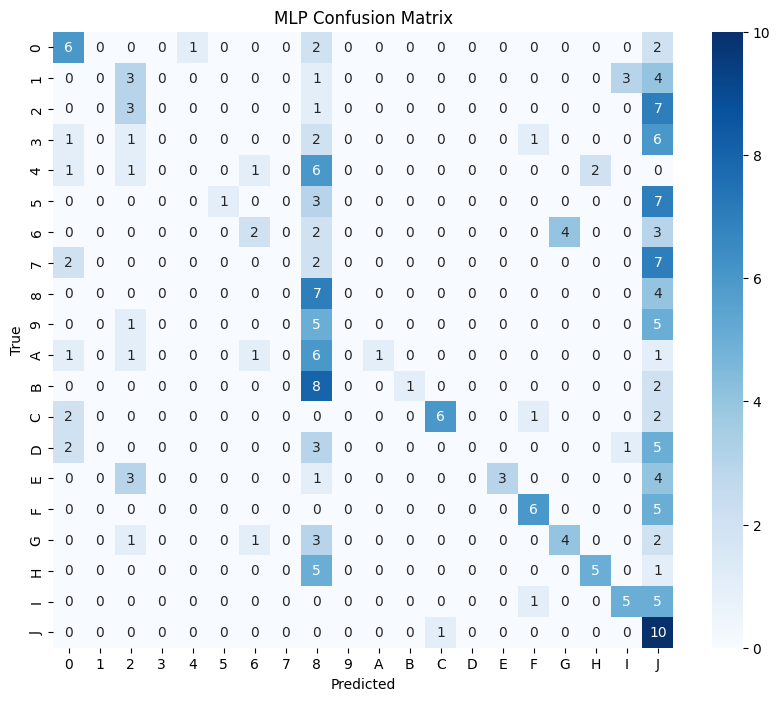

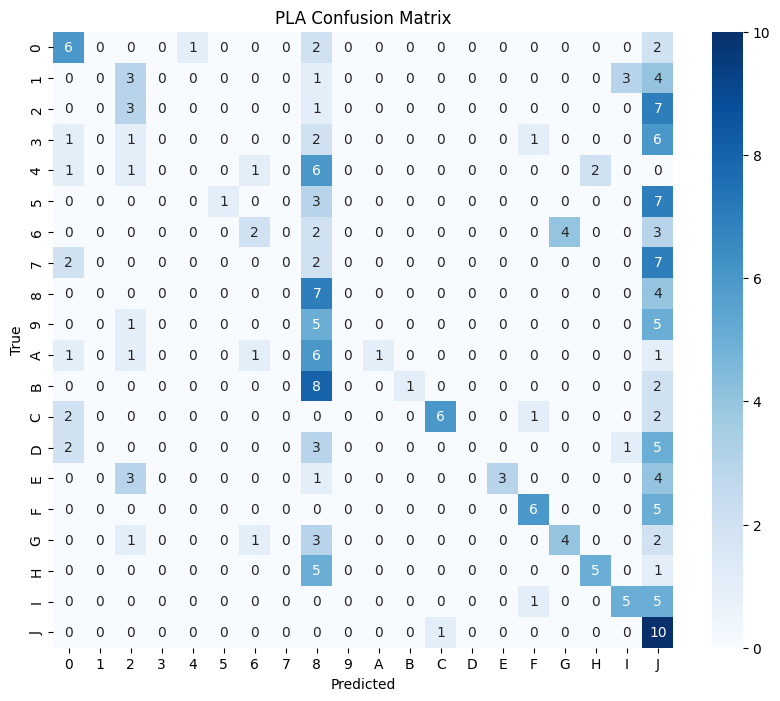

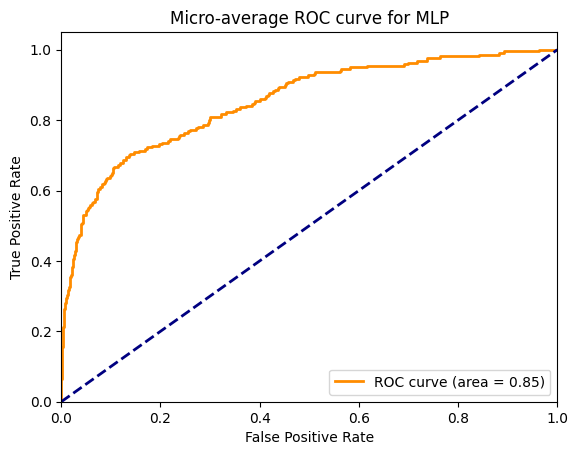

Training history not available to plot training curves for the final MLP model.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import torch
import torch.nn.functional as F

# Assuming y_test, y_pred_mlp, y_pred_pla, final_model (or model if you want to use the one from tuning),
# final_test_loader (or test_loader), NUM_CLASSES, and unique_classes are available from previous cells.
# Also assuming 'history' dictionary with 'train_loss', 'val_loss', 'val_acc' exists if you want to plot training curves.

# Ensure y_pred_mlp and y_pred_pla are available
# If you ran the last cell with the final model training, y_pred_final is available.
# Let's use y_pred_final from the last cell as y_pred_mlp for consistency with the MLP evaluation.
if 'y_pred_final' in locals():
    y_pred_mlp = y_pred_final
else:
    # If y_pred_final is not available, run prediction with the best final_model
    # Assuming final_model and final_test_loader are available after tuning
    if 'final_model' in locals() and 'final_test_loader' in locals():
         _, y_pred_mlp, _ = eval_model(final_model, final_test_loader, device)
         print("Generated y_pred_mlp from final_model.")
    else:
         print("Error: final_model or final_test_loader not found. Cannot generate MLP predictions.")
         y_pred_mlp = None # Or handle error appropriately

# Ensure y_pred_pla is available
if 'y_pred_final' in locals():
    # If using the updated PLA cell (deadeee7), the final predictions are in y_pred_final
    # However, the user's comparison code uses y_pred_pla. Let's assume y_pred_pla is available from a previous PLA execution.
    # If the PLA cell was run and stored predictions in y_pred_final, you might need to adjust variable names.
    # Assuming the PLA evaluation cell (bdd55250) was run and defined y_pred_pla
    if 'predictions' in locals():
        y_pred_pla = predictions # Use predictions from cell bdd55250 as y_pred_pla
        print("Using 'predictions' from cell bdd55250 as y_pred_pla.")
    else:
         print("Error: y_pred_pla (or 'predictions') not found. Cannot compare PLA.")
         y_pred_pla = None # Or handle error appropriately
else:
     # Assuming y_pred_pla was defined in a previous cell
     if 'y_pred_pla' not in locals():
         print("Error: y_pred_pla not found. Cannot compare PLA.")
         y_pred_pla = None


if y_pred_mlp is not None and y_pred_pla is not None:
    # Evaluation (MLP vs PLA)
    print("MLP Classification Report:\n", classification_report(y_test, y_pred_mlp, target_names=unique_classes.astype(str), zero_division=0))
    print("PLA Classification Report:\n", classification_report(y_test, y_pred_pla, target_names=unique_classes.astype(str), zero_division=0))

    # Confusion Matrix Example (MLP)
    cm_mlp = confusion_matrix(y_test, y_pred_mlp)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_mlp, annot=True, fmt='d', cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes)
    plt.title("MLP Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Confusion Matrix Example (PLA)
    cm_pla = confusion_matrix(y_test, y_pred_pla)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm_pla, annot=True, fmt='d', cmap="Blues", xticklabels=unique_classes, yticklabels=unique_classes)
    plt.title("PLA Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC (micro-average) - Only for MLP as PLA is not probabilistic
    # Need a predict_proba function for the MLP model
    def predict_proba_mlp(model, loader, device):
        model.eval(); out=[]
        with torch.no_grad():
            for xb,_ in loader:
                logits = model(xb.to(device))
                out.append(F.softmax(logits,1).cpu().numpy())
        return np.vstack(out)

    # Ensure final_model and final_test_loader are available
    if 'final_model' in locals() and 'final_test_loader' in locals():
        probs_mlp = predict_proba_mlp(final_model, final_test_loader, device)
        y_onehot = np.eye(NUM_CLASSES)[y_test]
        fpr,tpr, _ = roc_curve(y_onehot.ravel(), probs_mlp.ravel())
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Micro-average ROC curve for MLP')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("Cannot plot ROC curve: final_model or final_test_loader not found.")


    # Plot Training Curves (Assuming 'history' is available from MLP training)
    # The current MLP tuning code doesn't explicitly create a 'history' dictionary in the global scope.
    # If you want to plot the training curves of the *final* model, you would need to capture
    # the loss and metrics during its training loop in cell 97vECP-3sn8Z.
    # As the current code doesn't do that, this part will be skipped or needs modification
    # of the training loop in cell 97vECP-3sn8Z to store history.
    # For now, let's add a placeholder or a check for the existence of 'history'.

    # Placeholder for plotting training curves if history is available
    # For the current notebook state, 'history' is not available globally from cell 97vECP-3sn8Z training.
    # You would need to capture training history in the final model training loop.
    # Example (if history was captured):
    # if 'history' in locals():
    #     plt.plot(history['train_loss'], label="train_loss")
    #     plt.plot(history['test_loss'], label="test_loss") # Assuming test_loss was recorded
    #     plt.plot(history['test_accuracy'], label="test_acc") # Assuming test_accuracy was recorded
    #     plt.legend()
    #     plt.title("Training Curves (Final MLP Model)")
    #     plt.xlabel("Epoch")
    #     plt.ylabel("Metric Value")
    #     plt.show()
    # else:
    print("Training history not available to plot training curves for the final MLP model.")

else:
    print("Cannot perform comparison: MLP or PLA predictions are missing.")